In [1]:
import math
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.optimize import root_scalar
import os
import torch
import torch.distributions.constraints as constraints
import pyro
import numpy as np
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import pyro.contrib.autoguide as autoguide
import pandas
import timeit
from pyro.infer.mcmc import MCMC, HMC, NUTS


# Data

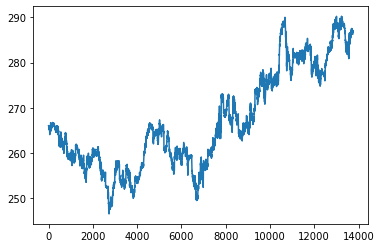

In [2]:
data=pandas.read_csv("MSFT.csv")
plt.plot(data["open"])
data=np.flip(data["open"].to_numpy())[:13500]
#plt.plot([i for i in range(len(data))],data)
plt.savefig("img.png",dpi=900)


# Black-Scholes model

## Euler-Maruyama approximated MLE

In [3]:
def approxmu(data):
    deltat=1/(505)
    s=0
    for i in range(1,len(data)):
        s=s+data[i]/data[i-1]-1
    s=s/(len(data)*deltat)
    return s

In [4]:
def approxsigma(data):
    mu=approxmu(data)
    deltat=1/(505)
    s=0
    for i in range(1,len(data)):
        s=s+(data[i]/data[i-1]-1-mu*deltat)**2/deltat
    s=math.sqrt(s)/(math.sqrt(len(data)))
    return s

In [5]:
print("Approx mu is", approxmu(data))
print("Approx sigma is", approxsigma(data))

Approx mu is -0.0024025781957533123
Approx sigma is 0.02490237861448845


## Exact MLE

In [6]:
def realk(data):
    deltat=1/(505)
    return (math.log(data[len(data)-1])-math.log(data[0]))/(len(data)*deltat)

In [7]:
def realsigma(data):
    k=realk(data)
    temp0=0
    deltat=1/(505)
    for i in range(1,len(data)):
        temp0=temp0+(math.log(data[i])-math.log(data[i-1])-k*deltat)**2
    s=math.sqrt(temp0)/math.sqrt(len(data)*deltat)
    return s

In [8]:
def realmu(data):
    return realk(data)+realsigma(data)**2/2


In [9]:
print("Approx mu is", approxmu(data))
print("Approx sigma is", approxsigma(data))
print("Real mu is", realmu(data))
print("Real sigma is", realsigma(data))

Approx mu is -0.0024025781957533123
Approx sigma is 0.02490237861448845
Real mu is -0.002402554985817001
Real sigma is 0.02490590039329626


# CEV Model

In [10]:
def cevsolution(data):
    deltat=1/505
    def sigmafunc(mu,gamma):
        temp0=0
        for i in range(1,len(data)):
            temp0=temp0+(data[i]/data[i-1]**gamma-data[i-1]**(1-gamma)*(1+mu*deltat))**2/deltat
        return math.sqrt(temp0)/math.sqrt(len(data))
    def mufunc(gamma):
        temp0=0
        temp1=0
        for i in range(1,len(data)):
            temp0=temp0+(data[i]/(data[i-1]**(2*gamma-1)))-data[i-1]**(2-2*gamma)
            temp1=temp1+data[i-1]**(2-2*gamma)
        return (temp0/temp1)*(1/deltat)
    def gammafunc(mu,sigma,gamma):
        temp0=0
        temp1=0
        for i in range(1,len(data)):
            temp0=temp0-math.log(data[i-1])
            temp1=temp1+(((1+mu*deltat)*data[i-1]-data[i])**2)*math.log(data[i-1])/(data[i-1]**(2*gamma)*sigma**2*deltat)
        return temp0+temp1
    def func(x):
        mu=mufunc(x)
        sigma=sigmafunc(mu,x)
        gamma=gammafunc(mu,sigma,x)
        return gamma
    gamma=root_scalar(func,bracket=[0,20]).root
    mu=mufunc(gamma)
    sigma=sigmafunc(mu,gamma)
    return mu,sigma,gamma
    
        
                         
                         

In [11]:
mu,sigma,gamma=cevsolution(data)
print("CEV mu is", mu)
print("CEV sigma is", sigma)
print("CEV gamma is", gamma)


CEV mu is -0.0024547298130310033
CEV sigma is 0.03568916672032402
CEV gamma is 0.9355761055580047


# Heston model

In [12]:
datacpu=torch.tensor(data.copy(),dtype=torch.float64)
datacuda=datacpu.to("cuda")

def computenu(nu,xi,theta,kappa,deltat,k):
    nutemp=nu
    for i in range(k):
            munu=kappa*(theta-nutemp)*deltat+nutemp
            sigmanu=xi*math.sqrt(nutemp)*2*math.sqrt(deltat)
            nutemp=dist.Normal(munu,sigmanu).sample()
            if nutemp<0:
                return computenu(xi,theta,kappa,k/10,10*k)

        

def heston(datacpu,datacuda):
    pyro.set_rng_seed(2022)
    use_cuda=True
    data=datacpu
    device="cpu"
    if use_cuda==True:
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        data=datacuda
        device="cuda"
    deltat=1/(505)
    def model(data):
        xi=pyro.param("xi", torch.tensor(2.,dtype=torch.float64),constraint=constraints.positive).type_as(data)
        theta=pyro.param("theta", torch.tensor(10.,dtype=torch.float64)).type_as(data)
        #enforces Feller condition
        kappa=xi**2/(2*theta)+1
        mu=approxmu(data)
        s=data[0]
        nu=torch.tensor(6.).type_as(data)
        for i in pyro.plate("observed data",len(data) ,use_cuda=use_cuda, device=device):
            mus=(1+mu*deltat)*s
            sigmas=math.sqrt(nu)*s**2*math.sqrt(deltat)
            munu=kappa*(theta-nu)*deltat+nu
            sigmanu=xi*math.sqrt(nu)*2*math.sqrt(deltat)
            s=pyro.sample("s_{}".format(i),dist.Normal(mus,sigmas) ,obs=data[i])
            nu=pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu))
            #### if nu<0 apply the varyng step stochastic algorithm from d'Onifrio et at al.
            if nu<0:
                nu=computenu(xi,theta,kappa,deltat,1)
    
    def guide(data):
        muguide=pyro.param("muguide", torch.tensor(100.,dtype=torch.float64)).type_as(data)
        sigmaguide=pyro.param("sigmaguide", torch.tensor(1.,dtype=torch.float64)).type_as(data)
        for i in pyro.plate("observed data",len(data) ,use_cuda=use_cuda, device=device):
            pyro.sample("nu_{}".format(i),dist.Normal(muguide,sigmaguide))
    adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    n_steps = 5000
    tmp=svi.evaluate_loss(data)
    losses=[]
    batchsize=500
    # do gradient steps
    for step in range(n_steps):
        tmpold=tmp
        loss=svi.step(data[((step*batchsize)%len(data)):(step*batchsize)%len(data)+batchsize])
        losses.append(loss)
        if step % 100 == 0:
            print('.', end='')
    plt.plot(losses)
    xi=pyro.param("xi")
    theta=pyro.param("theta")
    k=xi**2/(2*theta)+1
    print("Heston mu is", mu.item())
    print("Heston k is", k.item())
    print("Heston theta is", theta.item())
    print("Heston xi is", xi.item())                 

..................................................Heston mu is -0.0024547298130310033
Heston k is 3.7845938144669855
Heston theta is 12.082636361844605
Heston xi is 8.203076797841938


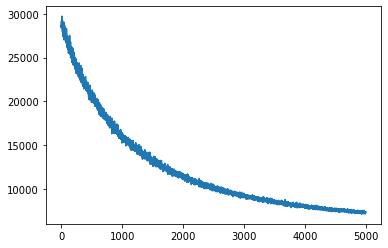

In [13]:
heston(datacpu,datacuda)